In [1]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Info on the dataset**

In [3]:
normal_dir = os.path.join('/content/drive/MyDrive/pneumonia/train/NORMAL')
pneumo_dir = os.path.join('/content/drive/MyDrive/pneumonia/train/PNEUMONIA')

print('total training normal images:', len(os.listdir(normal_dir)))
print('total training pneumonia images:', len(os.listdir(pneumo_dir)))

total training normal images: 1315
total training pneumonia images: 3876


In [4]:
normal_files = os.listdir(normal_dir)
print(normal_files[:10])

pneumo_files = os.listdir(pneumo_dir)
print(pneumo_files[:10])

['IM-0532-0001.jpeg', 'IM-0533-0001-0002.jpeg', 'IM-0528-0001.jpeg', 'IM-0535-0001.jpeg', 'IM-0533-0001.jpeg', 'IM-0525-0001-0002.jpeg', 'IM-0526-0001.jpeg', 'IM-0525-0001.jpeg', 'IM-0531-0001.jpeg', 'IM-0523-0001-0003.jpeg']
['person544_virus_1078.jpeg', 'person543_virus_1073.jpeg', 'person544_virus_1079.jpeg', 'person545_bacteria_2288.jpeg', 'person540_bacteria_2271.jpeg', 'person545_bacteria_2290.jpeg', 'person545_bacteria_2287.jpeg', 'person540_bacteria_2273.jpeg', 'person53_bacteria_255.jpeg', 'person541_bacteria_2275.jpeg']


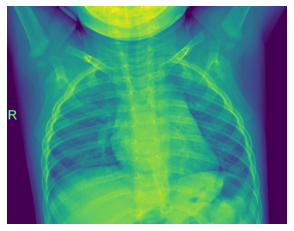

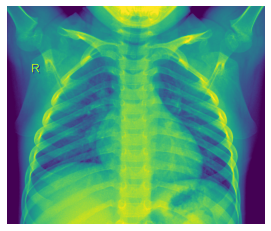

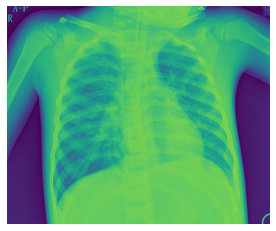

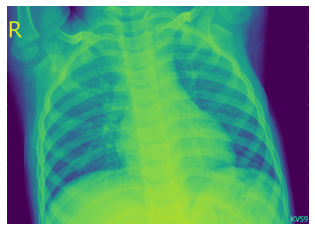

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_normal = [os.path.join(normal_dir, fname) 
                for fname in normal_files[pic_index-2:pic_index]]
next_pneumo = [os.path.join(pneumo_dir, fname) 
                for fname in pneumo_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_normal+next_pneumo):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

**Convolutional Layer**

In [14]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator 

TRAINING_DIR = "/content/drive/MyDrive/pneumonia/train"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/drive/MyDrive/pneumonia/test"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size= 128
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size= 128
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3) , activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3) , activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3) , activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3) , activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

METRICS = [
           'accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=METRICS)

history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("my_model.h5")

Found 5190 images belonging to 2 classes.
Found 634 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 74, 74, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 128)       73856     
                                     

KeyboardInterrupt: ignored

**Fine Tuning the Model**

##Improves the learning rate


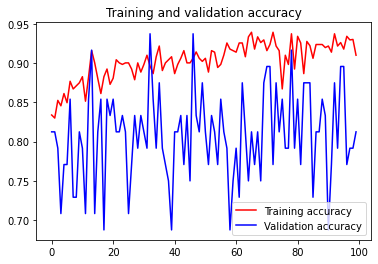

<Figure size 432x288 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Saving IM-0028-0001.jpeg to IM-0028-0001.jpeg
0.0


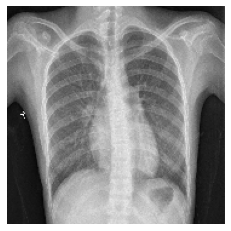

RESULT IS PNEUMONIA


In [12]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  #print(fn)
  print(classes[0][0])
  if (classes[0][0] >= 0.5):
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    print("RESULT IS NORMAL")
  else:
    plt.imshow(img)
    plt.axis('Off')
    plt.show()
    print("RESULT IS PNEUMONIA")